The circled spikes sound like button pressing, so use this to align the EEG and audio. This is not accurate.

![](img/img12.png)

The progress was controled by patient event trigger: trial starts after trigger pressed;

Grid A was over the Left central sulcus and grid B was over the Left inferior frontal gyrus.

Channel names:  1a,2a,3a,Tr1,4a,O1,F3,C3,P3,Fpz,Fz,Cz,ref,1b,2b,3b,Tr2,4b,1c,2c,3c,4c,X1,X2,DIF1,DIF2,DIF3,DIF4,DC1,DC2,DC3,DC4,OSAT,PR;

In [1]:
import calendar
import datetime
import glob
from utils.util_MNE import delete_annotation, keep_annotation
from dSPEECH.config import *

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [54]:
sf=512
type='ECoG' #'SEEG/ECoG
sid=3 # SEEG 1/2
folder_tmp=data_dir+'raw/'+type+str(sid)+'_*'
folder=os.path.normpath(glob.glob(folder_tmp)[0])
eeg_file=folder+'/*.edf' # SEEG1_datetime
eeg_file=os.path.normpath(glob.glob(eeg_file)[0])
raw = mne.io.read_raw_edf(eeg_file,preload=True)

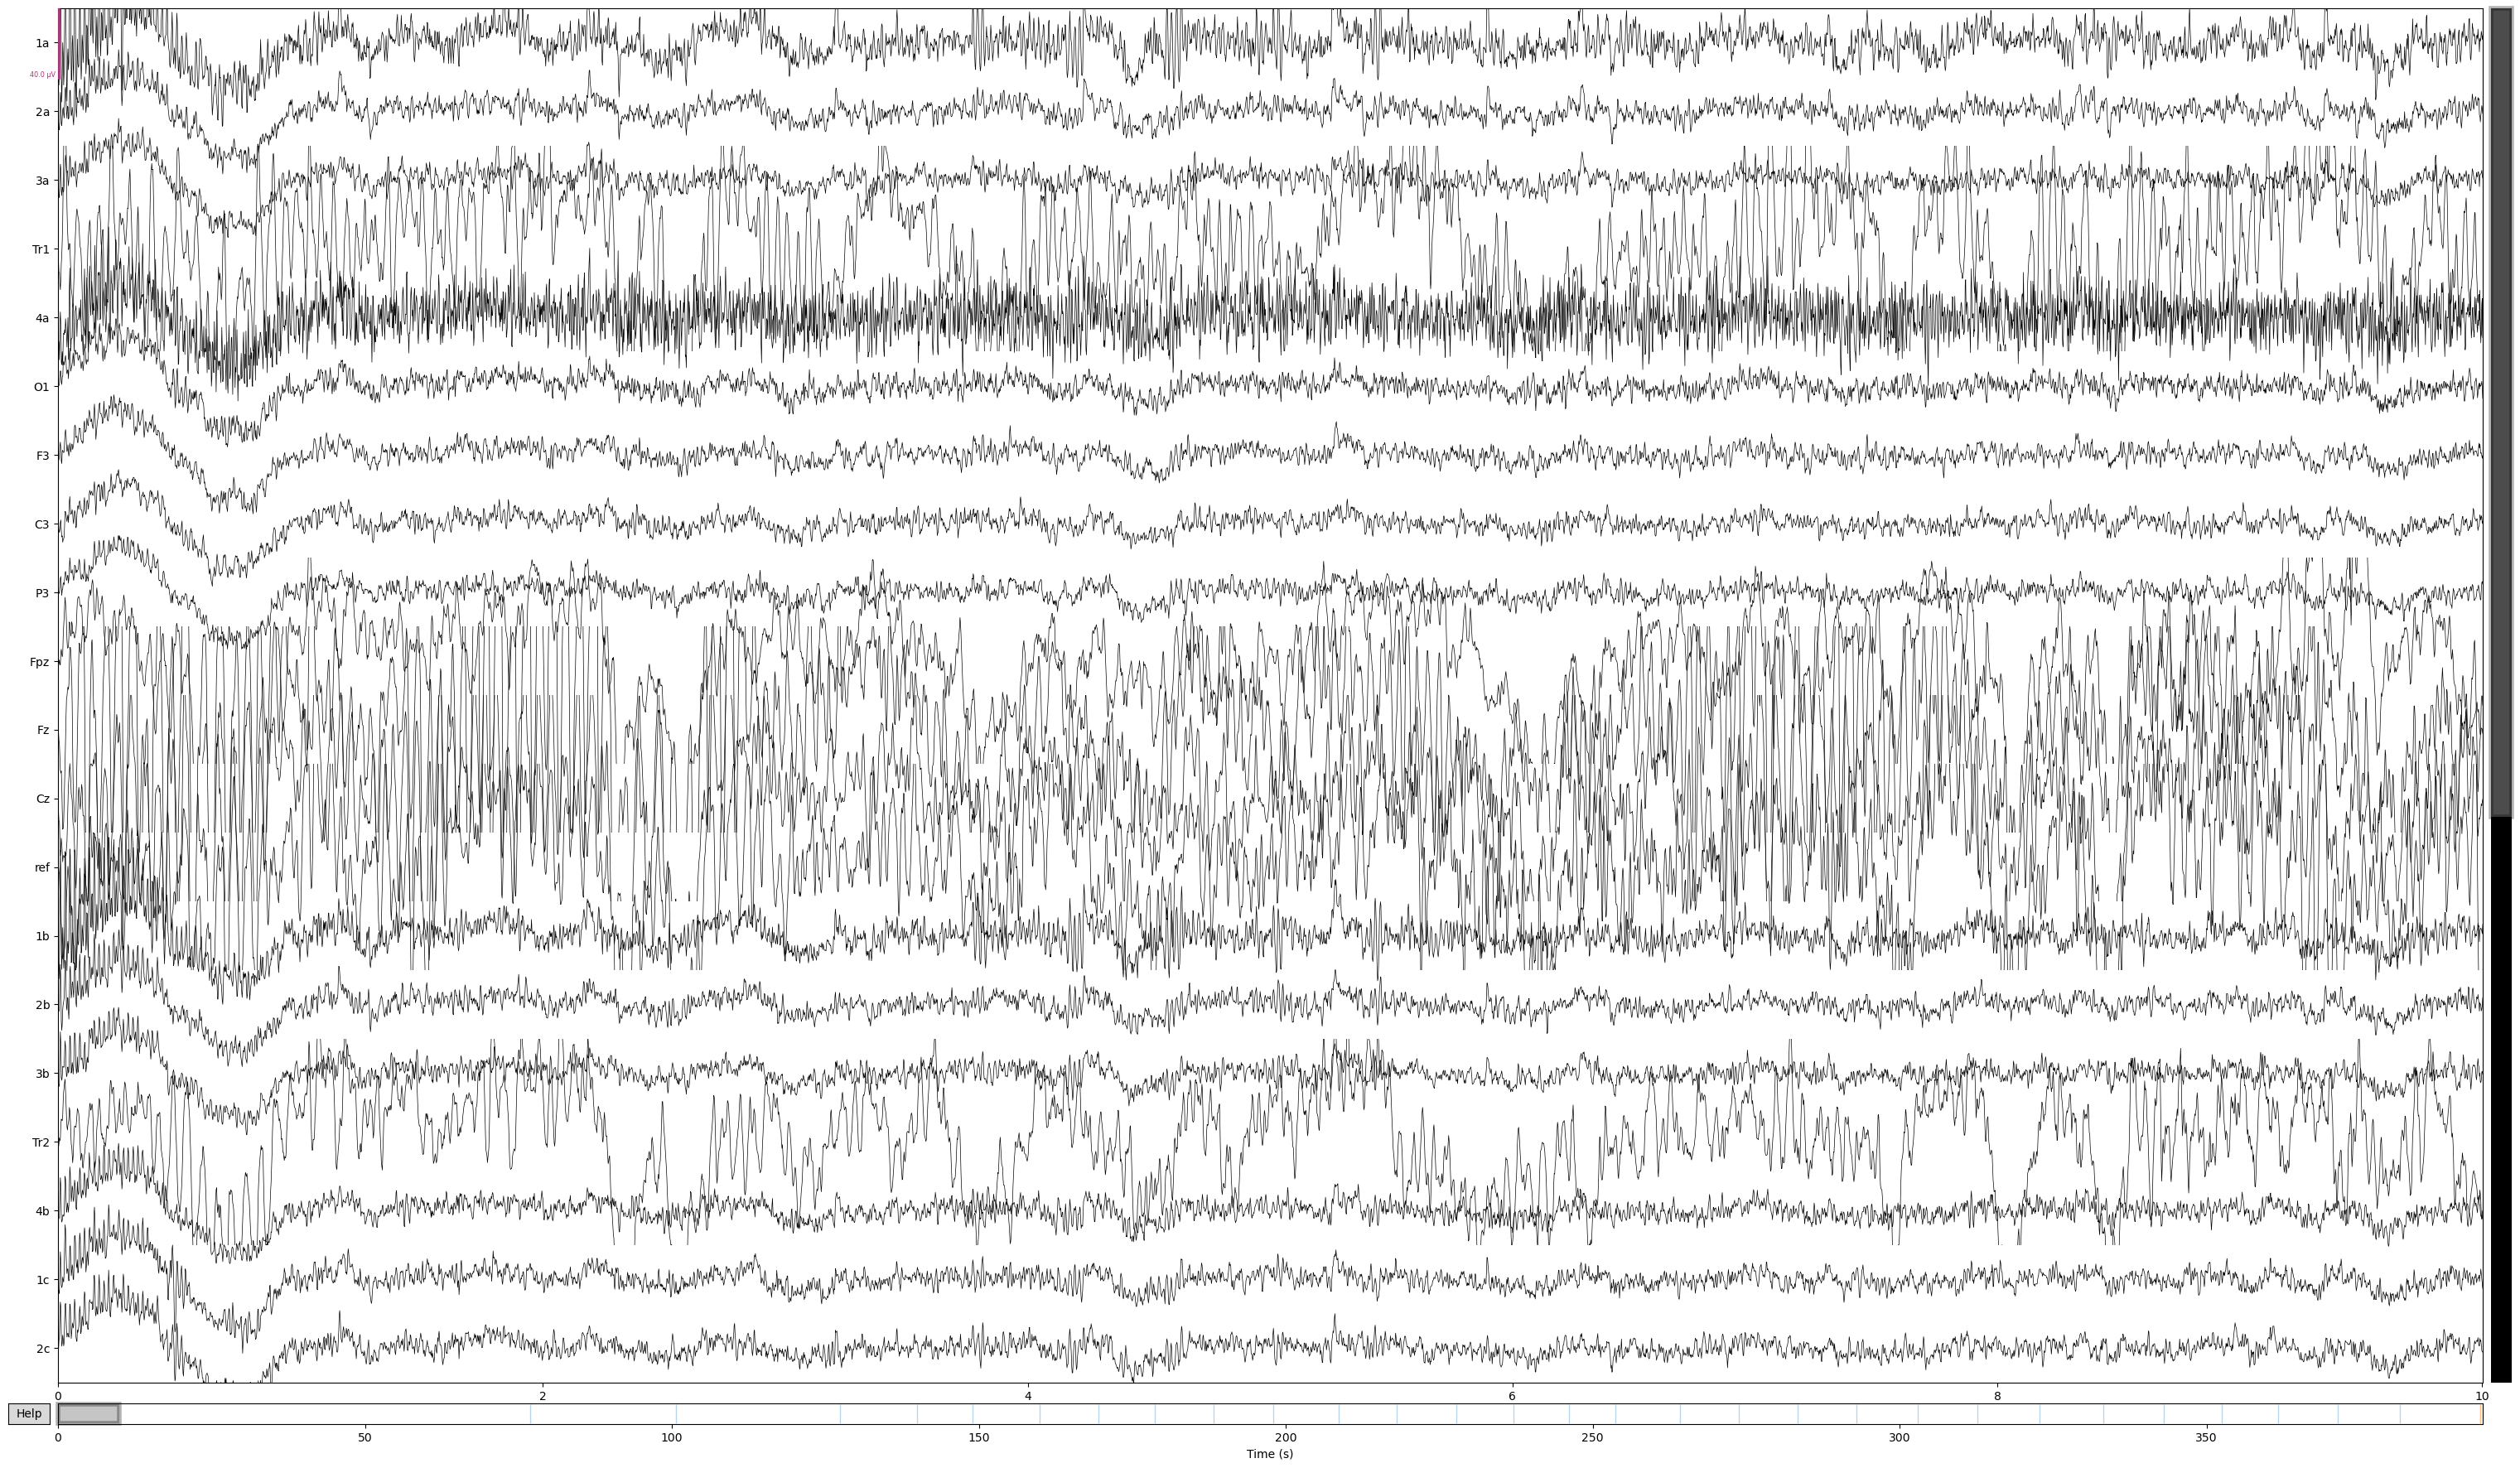

In [19]:
%matplotlib qt
raw.plot()

In [55]:
# line noise
freqs = (50,100,150,200,250)
raw.notch_filter(freqs=freqs)
# possible low frequency drift
cutoff=1
raw.filter(l_freq=cutoff, h_freq=None)

Measurement date,"October 18, 2024 11:54:53 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,34 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,256.00 Hz


In [21]:
anno=raw.annotations

In [7]:
anno # 29 trials, miss one trigger;

<Annotations | 31 segments: Patient Event (29), Stop Recording (2)>

In [6]:
filename=os.path.normpath(folder+'/inf.txt') # SEEG1_datetime
with open(filename,"r",encoding='utf-8') as infile:
    lines_tmp=infile.read().split('\n')
prompts_tmp=[tmpi for tmpi in lines_tmp if len(tmpi)>0] #

In [7]:
# format to lines in the form of "time, sentence";
prompts=[] # 33=3+30 trials;
for i in range(len(prompts_tmp)):
    tmp=[]
    tmp.append(prompts_tmp[i][:20])
    tmp.append(prompts_tmp[i][20:])
    prompts.append(tmp)


In [8]:
intervals=[]
for i in range(3,len(prompts)-1):
    tmp1 = prompts[i][0]
    tmp2=prompts[i+1][0]
    format = "%d-%b-%Y %H:%M:%S"
    tmp1=datetime.strptime(tmp1, format)
    tmp2=datetime.strptime(tmp2, format)
    diff=(tmp2-tmp1).seconds
    intervals.append(diff)

In [9]:
intervals.insert(0,999) # 999: a random number
trigger_matlab=np.cumsum(intervals)

In [10]:
from matplotlib import pyplot as plt
fig,ax=plt.subplots()
for aa in trigger_matlab:
    ax.axvline(x=aa, color='green', linestyle='-')

The first trigger is missing in Natus. The rest are there, just as the same as those exported from Matlab log.

![](img/12.png)

In [18]:
from scipy.io import wavfile
filename=folder+'/recording.wav'
sf,audio=wavfile.read(filename) # length: 374.19s

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_46108\3289792349.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf,audio=wavfile.read(filename) # same length as in Matlab using psychwavread


In [41]:
# prompts[-4] (['18-Oct-2024 12:06:24','ting-Cam-Pon']) corresponds to anno[-6] (at 352.464844s)
# button was pressed at offset of button_press for prompts[-4]. Whole audio was made up of [first_part, second_part], which was seperated by button_press;
button_press=5*60+36.053 # 336.053 s; visual check the button press events in Audacity;
# first part length=336.053
# second part length=374.19-button_press=38.137

In [45]:
anno_natus=keep_annotation(anno,'Patient Event')
raw.set_annotations(anno_natus)

Measurement date,"October 18, 2024 11:54:53 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,34 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,256.00 Hz


In [46]:
min=352.464844-336.053
max=352.464844+38.137
raw2=raw.crop(tmin=min,tmax=max)

ValueError: tmax (390.601844) must be less than or equal to the max time (374.1895 s)

In [53]:
trial_starts=[] # 29 trials
trial_lengths=[] # 28
for i in range(len(anno_natus)):
    trial_start=anno_natus[i]['onset']
    trial_starts.append(trial_start)
    if i<len(anno_natus)-1:
        next_start=anno_natus[i+1]['onset']
        trial_lengths.append(next_start-trial_start)

In [60]:
trial_datas=[]
raw_data=raw.get_data()
for i in range(len(trial_lengths)):
    trial_length=int(trial_lengths[i]*512)
    start=int(512*trial_starts[i])
    trial_datas.append(raw_data[:,start:(start+trial_length)])